# Project : Investigate a Dataset - Soccer Database

## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
### Dataset Description
![Database Diagram](db_diagram.png)

## My Questions for Analysis
1. Which kind of player attributes are the most important to team's success ?
2. What is the best age of a player ?
3. In English Premier League, which team have strongest attack(scores) ?
4. In English Premier League, which team got most points ?
5. Which season in English Premier League has the most goals ?

## How to approach to answer these questions:
### For All Questions:
* SQL Join together to calculate goals of each team.
* check null, if any remove.
* check duplicate , if any remove.

### For Question 1:
* The success of team will be the rank or points of a whole season. So I will calculate the rank and points of all teams in English Premier League.
* Join player with match that they played, and calculate average attribute per season.
* Find out which attributes have strong correlation with points/rank.
* With these attributes , I can know that which position is the most important to win the game. And I will sign more player in this position ( forward ? midfield? defender ? goalkeeper ? )


### For Question 2:
* Check outlier of age.
* I will calculate overall rating of player year by year.
* group by player and his age then rank his overall ( ex : Age 19 = rank 1, Age 20 = rank 2 ...)
* So I will get only rank 1 of all players then find out which age is the peak of player.





In [1]:
# import library
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb


<a id='wrangling'></a>
## Data Wrangling


In [2]:
# connect and load database
db_file = 'database.sqlite'
conn = sqlite3.connect(db_file)

### Calculate matches points and rank of team per season

In [3]:
# remove outlier.
def remove_outlier(_df, col_name):
    """
    remove outliers
    """
    q1 = _df[col_name].quantile(0.25)
    q3 = _df[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = _df.loc[(_df[col_name] > fence_low) & (_df[col_name] < fence_high)]
    return df_out

In [4]:
def eleven_player_columns(is_home=True):
    """
    get 11 players column name of match
    :param is_home:
    :return:
    """
    prefix = 'home_player_' if is_home else 'away_player_'
    return [f'{prefix}{i}' for i in range(1, 12)]


In [5]:
# home & away columns
home_players = eleven_player_columns()
away_players = eleven_player_columns(False)

In [6]:
# get all matches of England Premier League ( because Arsenal plays in this league )
df_match = pd.read_sql(
    f"SELECT season,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,{','.join(home_players)},{','.join(away_players)} FROM League JOIN Match M ON League.id = M.league_id WHERE name = 'England Premier League';",
    conn)
df_match.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 27 columns):
season              3040 non-null object
home_team_api_id    3040 non-null int64
away_team_api_id    3040 non-null int64
home_team_goal      3040 non-null int64
away_team_goal      3040 non-null int64
home_player_1       3040 non-null int64
home_player_2       3033 non-null float64
home_player_3       3040 non-null int64
home_player_4       3040 non-null int64
home_player_5       3037 non-null float64
home_player_6       3040 non-null int64
home_player_7       3035 non-null float64
home_player_8       3033 non-null float64
home_player_9       3038 non-null float64
home_player_10      3033 non-null float64
home_player_11      3039 non-null float64
away_player_1       3040 non-null int64
away_player_2       3032 non-null float64
away_player_3       3039 non-null float64
away_player_4       3040 non-null int64
away_player_5       3033 non-null float64
away_player_6       3036 non-nul

In [7]:
# look at data
df_match.head()

,season,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
0,2008/2009,10260,10261,1,1,30726,30362.0,30620,30865,32569.0,...,25518.0,24228.0,30929,29581.0,38807.0,40565.0,30360.0,33852.0,34574.0,37799.0
1,2008/2009,9825,8659,1,0,23686,26111.0,38835,30986,31291.0,...,36832.0,23115.0,37280,24728.0,24664.0,31088.0,23257.0,24171.0,25922.0,27267.0
2,2008/2009,8472,8650,0,1,32562,38836.0,24446,24408,36786.0,...,37442.0,30617.0,24134,414792.0,37139.0,30618.0,40701.0,24800.0,24635.0,30853.0
3,2008/2009,8654,8528,2,1,36374,30966.0,23818,37277,30687.0,...,34987.0,35472.0,111865,25005.0,35327.0,25150.0,97988.0,41877.0,127857.0,34466.0
4,2008/2009,10252,8456,4,2,30380,30357.0,24658,43280,23282.0,...,46403.0,24208.0,23939,33963.0,47413.0,40198.0,42119.0,NaN,33633.0,107216.0


In [8]:
# convert season to integer number , so I can easier to join with player data later
df_match['season_start_year'] = df_match.season.str[:4].astype(int)
df_match.head()

,season,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,...,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,season_start_year
0,2008/2009,10260,10261,1,1,30726,30362.0,30620,30865,32569.0,...,24228.0,30929,29581.0,38807.0,40565.0,30360.0,33852.0,34574.0,37799.0,2008
1,2008/2009,9825,8659,1,0,23686,26111.0,38835,30986,31291.0,...,23115.0,37280,24728.0,24664.0,31088.0,23257.0,24171.0,25922.0,27267.0,2008
2,2008/2009,8472,8650,0,1,32562,38836.0,24446,24408,36786.0,...,30617.0,24134,414792.0,37139.0,30618.0,40701.0,24800.0,24635.0,30853.0,2008
3,2008/2009,8654,8528,2,1,36374,30966.0,23818,37277,30687.0,...,35472.0,111865,25005.0,35327.0,25150.0,97988.0,41877.0,127857.0,34466.0,2008
4,2008/2009,10252,8456,4,2,30380,30357.0,24658,43280,23282.0,...,24208.0,23939,33963.0,47413.0,40198.0,42119.0,NaN,33633.0,107216.0,2008


In [9]:
# calculate points for match
# win : 3 points , draw : 1 points , lose: 0 points
df_match['home_team_point'] = np.select([df_match.home_team_goal > df_match.away_team_goal, df_match.home_team_goal == df_match.away_team_goal], [3, 1], 0)
df_match['away_team_point'] = np.select([df_match.away_team_goal > df_match.home_team_goal, df_match.away_team_goal == df_match.home_team_goal], [3, 1], 0)
df_match[['home_team_goal', 'away_team_goal', 'home_team_point', 'away_team_point']].head()

,home_team_goal,away_team_goal,home_team_point,away_team_point
0,1,1,1,1
1,1,0,3,0
2,0,1,0,3
3,2,1,3,0
4,4,2,3,0


In [10]:
# goals per team, season
df_home_goal = df_match.groupby(['home_team_api_id', 'season_start_year']).home_team_goal.sum()
df_away_goal = df_match.groupby(['away_team_api_id', 'season_start_year']).away_team_goal.sum()

In [11]:
# points per season , matches count per season
df_home_point = df_match.groupby(['home_team_api_id', 'season_start_year']).home_team_point.agg(['sum', 'count'])
df_away_point = df_match.groupby(['away_team_api_id', 'season_start_year']).away_team_point.agg(['sum', 'count'])

In [12]:
df_home_point.head()

sum  count
home_team_api_id season_start_year            
8191             2009                26     19
                 2014                19     19
8197             2014                26     19
                 2015                42     19
8344             2013                20     19

In [13]:
df_away_point.head()

sum  count
away_team_api_id season_start_year            
8191             2009                 4     19
                 2014                14     19
8197             2014                15     19
                 2015                39     19
8344             2013                10     19

In [14]:
# merge points (home matches + away matches)
df_point = df_home_point + df_away_point
df_point.head()

sum  count
home_team_api_id season_start_year            
8191             2009                30     38
                 2014                33     38
8197             2014                41     38
                 2015                81     38
8344             2013                30     38

In [15]:
# merge goals (home matches + away matches)
df_goal = df_home_goal + df_away_goal
df_goal = df_goal.reset_index().rename(columns={'home_team_api_id':'team_api_id',0:'goal'})
df_goal.head()

,team_api_id,season_start_year,goal
0,8191,2009,42
1,8191,2014,28
2,8197,2014,46
3,8197,2015,68
4,8344,2013,32


In [16]:
# rank team per season
df_point['rank'] = df_point.groupby('season_start_year')['sum'].rank('dense', ascending=False)
df_point['rank'] = df_point['rank'].astype(int)
df_point.sort_values(['season_start_year', 'rank'], ascending=[True, True], inplace=True)
df_point.head()

,,sum,count,rank
home_team_api_id,season_start_year,,,
10260,2008,90,38,1
8650,2008,86,38,2
8455,2008,83,38,3
9825,2008,72,38,4
8668,2008,63,38,5


In [17]:
# check if all team have same 38 matches
df_point['count'].unique()

array([38])

In [18]:
# Teams information
df_team = pd.read_sql("SELECT * FROM TEAM", conn)
df_team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [19]:
# join team name with team result
df_rank = pd.merge(df_point.reset_index(), df_team, left_on='home_team_api_id', right_on='team_api_id')
df_rank = df_rank.drop(['home_team_api_id', 'count', 'id', 'team_fifa_api_id'], axis=1).rename(columns={'sum': 'points'})
df_rank.head()

,season_start_year,points,rank,team_api_id,team_long_name,team_short_name
0,2008,90,1,10260,Manchester United,MUN
1,2009,85,2,10260,Manchester United,MUN
2,2010,80,1,10260,Manchester United,MUN
3,2011,89,1,10260,Manchester United,MUN
4,2012,89,1,10260,Manchester United,MUN


In [20]:
# sort by season and rank
df_rank.sort_values(['season_start_year', 'rank'], ascending=[True, True])
df_rank.head()

,season_start_year,points,rank,team_api_id,team_long_name,team_short_name
0,2008,90,1,10260,Manchester United,MUN
1,2009,85,2,10260,Manchester United,MUN
2,2010,80,1,10260,Manchester United,MUN
3,2011,89,1,10260,Manchester United,MUN
4,2012,89,1,10260,Manchester United,MUN


### Player Attribute

In [21]:
# get player attributes from database
df_player_attr = pd.read_sql("select * from Player_Attributes", conn)
df_player_attr.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [22]:
df_player_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
accele

In [23]:
# fill missing object data
def print_col_unique(df, cols):
    for _col in cols:
        print(_col, df[_col].unique())

object_cols = ['preferred_foot','attacking_work_rate','defensive_work_rate']
print_col_unique(df_player_attr,object_cols)


preferred_foot ['right' 'left' None]
attacking_work_rate ['medium' 'high' None 'low' 'None' 'le' 'norm' 'stoc' 'y']
defensive_work_rate ['medium' 'high' 'low' '_0' None '5' 'ean' 'o' '1' 'ormal' '7' '2' '8' '4'
 'tocky' '0' '3' '6' '9' 'es']


In [24]:
# convert object data to number
# high : 3 , medium : 2 , low 1, others : 2(medium)
# right : 2 , left : 2 , None: 2
for col in object_cols:
    df_player_attr[col]= np.select([df_player_attr[col] == 'high',df_player_attr[col] == 'low'],[3,1],2)

print_col_unique(df_player_attr,object_cols)

preferred_foot [2]
attacking_work_rate [2 3 1]
defensive_work_rate [2 3 1]


In [25]:
df_player_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183978 non-null int64
attacking_work_rate    183978 non-null int64
defensive_work_rate    183978 non-null int64
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
accelerat

In [26]:
# date column is the day that player rated. but we can not relate this day with season.
# because almost season end in 30th May, so we use this day to find "season_start_year"
df_player_attr.date = pd.to_datetime(df_player_attr.date)
df_player_attr['season_start_year'] = np.where(df_player_attr.date.dt.month > 5, df_player_attr.date.dt.year,
                                               df_player_attr.date.dt.year - 1)
df_player_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 43 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null datetime64[ns]
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183978 non-null int64
attacking_work_rate    183978 non-null int64
defensive_work_rate    183978 non-null int64
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
a

In [27]:
numerics = ['float16', 'float32', 'float64']
number_cols = df_player_attr.select_dtypes(include=numerics).columns.tolist()
number_cols

['overall_rating',
 'potential',
 'crossing',
 'finishing',
 'heading_accuracy',
 'short_passing',
 'volleys',
 'dribbling',
 'curve',
 'free_kick_accuracy',
 'long_passing',
 'ball_control',
 'acceleration',
 'sprint_speed',
 'agility',
 'reactions',
 'balance',
 'shot_power',
 'jumping',
 'stamina',
 'strength',
 'long_shots',
 'aggression',
 'interceptions',
 'positioning',
 'vision',
 'penalties',
 'marking',
 'standing_tackle',
 'sliding_tackle',
 'gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_positioning',
 'gk_reflexes']

In [28]:
# fill missing data with mean
attr_cols = object_cols + number_cols
df_player_attr_mean = df_player_attr.copy()
df_player_attr_mean[attr_cols] = df_player_attr[attr_cols].fillna(df_player_attr[attr_cols].mean())

# to make sure there are no missing value
df_player_attr_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 43 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null datetime64[ns]
overall_rating         183978 non-null float64
potential              183978 non-null float64
preferred_foot         183978 non-null int64
attacking_work_rate    183978 non-null int64
defensive_work_rate    183978 non-null int64
crossing               183978 non-null float64
finishing              183978 non-null float64
heading_accuracy       183978 non-null float64
short_passing          183978 non-null float64
volleys                183978 non-null float64
dribbling              183978 non-null float64
curve                  183978 non-null float64
free_kick_accuracy     183978 non-null float64
long_passing           183978 non-null float64
ball_control           183978 non-null float64
a

In [29]:
# calculate mean per season, player
df_player_attr_per_season = df_player_attr_mean.groupby(['player_api_id', 'season_start_year'], as_index=False)[attr_cols].mean()
df_player_attr_per_season.head(9)


,player_api_id,season_start_year,preferred_foot,attacking_work_rate,defensive_work_rate,overall_rating,potential,crossing,finishing,heading_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,2625,2006,2.0,3.0,2.0,63.0,64.0,48.000000,48.0,47.0,...,56.0,46.0,64.000000,66.0,63.000000,14.0,11.0,67.0,9.0,10.0
1,2625,2007,2.0,3.0,2.0,63.0,64.0,48.000000,48.0,47.0,...,56.0,46.0,64.000000,66.0,63.000000,14.0,24.0,67.0,24.0,24.0
2,2625,2008,2.0,3.0,2.0,60.0,64.0,48.000000,48.0,47.0,...,56.0,46.0,64.000000,66.0,63.000000,14.0,24.0,67.0,24.0,24.0
3,2625,2010,2.0,3.0,2.0,59.5,63.5,50.000000,47.5,46.5,...,55.5,67.5,63.500000,64.5,62.500000,12.0,11.0,6.0,8.0,8.0
4,2625,2011,2.0,2.5,2.0,58.0,58.0,52.000000,47.0,46.0,...,55.0,66.0,63.000000,63.0,52.000000,12.0,11.0,6.0,8.0,8.0
5,2625,2012,2.0,2.0,2.0,59.0,59.0,51.333333,47.0,46.0,...,55.0,66.0,62.666667,63.0,52.666667,12.0,11.0,6.0,8.0,8.0
6,2625,2013,2.0,2.0,2.0,61.0,61.0,50.000000,47.0,46.0,...,55.0,66.0,62.000000,63.0,54.000000,12.0,11.0,6.0,8.0,8.0
7,2625,2014,2.0,2.0,2.0,61.0,61.0,50.000000,47.0,46.0,...,55.0,66.0,62.000000,63.0,54.000000,12.0,11.0,6.0,8.0,8.0
8,2752,2006,2.0,2.0,2.0,62.0,68.0,36.000000,37.0,70.0,...,52.0,35.0,64.000000,60.0,65.000000,11.0,6.0,7.0,9.0,15.0


> we found that some year missing in player atrributes dataset (ex: 2009)
> we need to generate 2009 data from nearest year (2008 or 2010), so we can join data with rank dataset

### Get min max year of all datasets , we need to forward fill year for player attributes dataset , so we can join with rank dataset

In [30]:
# get min max year of match
df_match.season_start_year.agg(['min', 'max'])

min    2008
max    2015
Name: season_start_year, dtype: int64

In [31]:
# get min max year of player attributes
df_player_attr_per_season.season_start_year.agg(['min', 'max'])

min    2006
max    2016
Name: season_start_year, dtype: int64

In [32]:
# get min max year of team rank
df_rank.season_start_year.agg(['min', 'max'])

min    2008
max    2015
Name: season_start_year, dtype: int64

In [33]:
#  fill missing year from 2008 to 2015 for attribute , so we can join 1 vs 1 with team rank dataframe
df_player_attr_final = df_player_attr_per_season.set_index('season_start_year').groupby('player_api_id', as_index=False).apply(lambda x: x.reindex(range(2008, 2016), method='ffill')).reset_index().drop('level_0', axis=1)
#df_player_attr_final = df_player_attr_final.convert_dtypes()

# make sure there is no null data
df_player_attr_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88480 entries, 0 to 88479
Data columns (total 40 columns):
season_start_year      88480 non-null int64
player_api_id          88480 non-null int64
preferred_foot         88480 non-null float64
attacking_work_rate    88480 non-null float64
defensive_work_rate    88480 non-null float64
overall_rating         88480 non-null float64
potential              88480 non-null float64
crossing               88480 non-null float64
finishing              88480 non-null float64
heading_accuracy       88480 non-null float64
short_passing          88480 non-null float64
volleys                88480 non-null float64
dribbling              88480 non-null float64
curve                  88480 non-null float64
free_kick_accuracy     88480 non-null float64
long_passing           88480 non-null float64
ball_control           88480 non-null float64
acceleration           88480 non-null float64
sprint_speed           88480 non-null float64
agility              

In [34]:
# check that we have all year data per player
df_player_attr_final.head(9)

,season_start_year,player_api_id,preferred_foot,attacking_work_rate,defensive_work_rate,overall_rating,potential,crossing,finishing,heading_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,2008,2625,2.0,3.0,2.0,60.0,64.0,48.000000,48.0,47.0,...,56.0,46.0,64.000000,66.0,63.000000,14.0,24.0,67.0,24.0,24.0
1,2009,2625,2.0,3.0,2.0,60.0,64.0,48.000000,48.0,47.0,...,56.0,46.0,64.000000,66.0,63.000000,14.0,24.0,67.0,24.0,24.0
2,2010,2625,2.0,3.0,2.0,59.5,63.5,50.000000,47.5,46.5,...,55.5,67.5,63.500000,64.5,62.500000,12.0,11.0,6.0,8.0,8.0
3,2011,2625,2.0,2.5,2.0,58.0,58.0,52.000000,47.0,46.0,...,55.0,66.0,63.000000,63.0,52.000000,12.0,11.0,6.0,8.0,8.0
4,2012,2625,2.0,2.0,2.0,59.0,59.0,51.333333,47.0,46.0,...,55.0,66.0,62.666667,63.0,52.666667,12.0,11.0,6.0,8.0,8.0
5,2013,2625,2.0,2.0,2.0,61.0,61.0,50.000000,47.0,46.0,...,55.0,66.0,62.000000,63.0,54.000000,12.0,11.0,6.0,8.0,8.0
6,2014,2625,2.0,2.0,2.0,61.0,61.0,50.000000,47.0,46.0,...,55.0,66.0,62.000000,63.0,54.000000,12.0,11.0,6.0,8.0,8.0
7,2015,2625,2.0,2.0,2.0,61.0,61.0,50.000000,47.0,46.0,...,55.0,66.0,62.000000,63.0,54.000000,12.0,11.0,6.0,8.0,8.0
8,2008,2752,2.0,2.0,2.0,65.0,68.0,36.000000,37.0,70.0,...,52.0,35.0,64.000000,60.0,65.000000,11.0,6.0,7.0,9.0,15.0


> all year from 2008 to 2015 was generated.

In [35]:
# get home players from match dataset
#df_match = df_match.convert_dtypes()
df_home_player = df_match.set_index(['season_start_year', 'home_team_api_id'])[home_players].stack().reset_index().rename(columns={'level_2': 'player_no', 0: 'player_api_id', 'home_team_api_id': 'team_api_id'})
df_home_player['player_api_id'] = df_home_player['player_api_id'].astype(int)
df_home_player.head()

,season_start_year,team_api_id,player_no,player_api_id
0,2008,10260,home_player_1,30726
1,2008,10260,home_player_2,30362
2,2008,10260,home_player_3,30620
3,2008,10260,home_player_4,30865
4,2008,10260,home_player_5,32569


In [36]:
# get away players from match dataset
df_away_player = df_match.set_index(['season_start_year', 'away_team_api_id'])[away_players].stack().reset_index().rename(columns={'level_2': 'player_no', 0: 'player_api_id', 'away_team_api_id': 'team_api_id'})
df_away_player['player_api_id'] = df_away_player['player_api_id'].astype(int)
df_away_player.head()

,season_start_year,team_api_id,player_no,player_api_id
0,2008,10261,away_player_1,24224
1,2008,10261,away_player_2,25518
2,2008,10261,away_player_3,24228
3,2008,10261,away_player_4,30929
4,2008,10261,away_player_5,29581


In [37]:
# merge home and away player together, so we have all player per year
df_player_final = pd.concat([df_home_player, df_away_player]).sort_values(['season_start_year', 'team_api_id', 'player_no']).drop('player_no', axis=1)
df_player_final.head()

,season_start_year,team_api_id,player_api_id
153,2008,8455,30859
393,2008,8455,30859
525,2008,8455,23984
843,2008,8455,30859
1019,2008,8455,30859


In [38]:
# join team and player attributes
df_match_player_attr = pd.merge(df_player_final, df_player_attr_final, on=['season_start_year', 'player_api_id'])
df_match_player_attr.head()

,season_start_year,team_api_id,player_api_id,preferred_foot,attacking_work_rate,defensive_work_rate,overall_rating,potential,crossing,finishing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,2008,8455,30859,2.0,2.0,2.0,88.0,91.0,20.0,20.0,...,45.0,54.5,20.0,20.0,12.0,94.0,89.5,79.0,85.5,90.0
1,2008,8455,30859,2.0,2.0,2.0,88.0,91.0,20.0,20.0,...,45.0,54.5,20.0,20.0,12.0,94.0,89.5,79.0,85.5,90.0
2,2008,8455,30859,2.0,2.0,2.0,88.0,91.0,20.0,20.0,...,45.0,54.5,20.0,20.0,12.0,94.0,89.5,79.0,85.5,90.0
3,2008,8455,30859,2.0,2.0,2.0,88.0,91.0,20.0,20.0,...,45.0,54.5,20.0,20.0,12.0,94.0,89.5,79.0,85.5,90.0
4,2008,8455,30859,2.0,2.0,2.0,88.0,91.0,20.0,20.0,...,45.0,54.5,20.0,20.0,12.0,94.0,89.5,79.0,85.5,90.0


In [39]:
# join rank and player attributes
df_all = pd.merge(df_rank, df_match_player_attr, on=['season_start_year', 'team_api_id'])
df_all.head()

,season_start_year,points,rank,team_api_id,team_long_name,team_short_name,player_api_id,preferred_foot,attacking_work_rate,defensive_work_rate,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,2008,90,1,10260,Manchester United,MUN,24157,2.0,3.0,1.0,...,60.0,59.0,22.0,28.5,30.0,12.0,22.0,31.0,22.0,22.0
1,2008,90,1,10260,Manchester United,MUN,30726,2.0,2.0,2.0,...,40.0,43.0,20.0,33.0,11.0,86.0,85.5,85.0,89.5,84.0
2,2008,90,1,10260,Manchester United,MUN,30726,2.0,2.0,2.0,...,40.0,43.0,20.0,33.0,11.0,86.0,85.5,85.0,89.5,84.0
3,2008,90,1,10260,Manchester United,MUN,30726,2.0,2.0,2.0,...,40.0,43.0,20.0,33.0,11.0,86.0,85.5,85.0,89.5,84.0
4,2008,90,1,10260,Manchester United,MUN,30726,2.0,2.0,2.0,...,40.0,43.0,20.0,33.0,11.0,86.0,85.5,85.0,89.5,84.0


In [40]:
# group by season and team , then calculate average attribute
df_all_mean = df_all.groupby(['season_start_year', 'rank', 'points', 'team_api_id', 'team_long_name', 'team_short_name'])[attr_cols].mean().reset_index()
df_all_mean.head()

,season_start_year,rank,points,team_api_id,team_long_name,team_short_name,preferred_foot,attacking_work_rate,defensive_work_rate,overall_rating,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,2008,1,90,10260,Manchester United,MUN,2.0,2.205742,2.234450,82.343301,...,73.913876,77.088517,54.531100,60.171053,55.366029,16.375598,26.998804,69.718900,27.273923,27.133971
1,2008,2,86,8650,Liverpool,LIV,2.0,2.282297,2.456938,81.504785,...,73.739234,78.066986,57.912679,62.095694,59.203349,16.476077,27.260766,70.813397,27.442584,27.988038
2,2008,3,83,8455,Chelsea,CHE,2.0,2.265550,2.220096,83.687799,...,74.688995,77.959330,57.380383,61.844498,60.021531,16.187799,27.962919,70.785885,27.623206,28.059809
3,2008,4,72,9825,Arsenal,ARS,2.0,2.244019,2.155502,80.101675,...,70.531100,72.471292,54.144737,60.681818,61.394737,14.210526,26.354067,68.351675,26.023923,27.241627
4,2008,5,63,8668,Everton,EVE,2.0,2.095694,2.217703,78.066986,...,73.337018,71.387560,60.533493,62.744019,60.866032,17.383971,29.191388,66.549043,28.863636,29.882775


<a id='eda'></a>
### Exploratory Data Analysis

#### Question 1: Which kind of player attributes are the most important to team's success ?

In [41]:
# calculate correlation of all attribute with rank
corrs = [(col, df_all_mean['rank'].astype(float).corr(df_all_mean[col].astype(float))) for col in attr_cols]
corrs.sort(key=lambda x: x[1])
corrs

[('preferred_foot', nan),
 ('overall_rating', -0.80137709329351348),
 ('ball_control', -0.76443949246883913),
 ('potential', -0.75589638085205069),
 ('reactions', -0.75494932841528406),
 ('short_passing', -0.72642315368587906),
 ('long_passing', -0.70993281213167492),
 ('crossing', -0.66974652971260695),
 ('curve', -0.66499961936121899),
 ('vision', -0.65021281550860688),
 ('long_shots', -0.64775513670440388),
 ('volleys', -0.63106508179257759),
 ('dribbling', -0.61789278578836704),
 ('finishing', -0.61536884828666683),
 ('shot_power', -0.60839117403364573),
 ('free_kick_accuracy', -0.60097467201444965),
 ('acceleration', -0.55648124814114186),
 ('agility', -0.54476856709524746),
 ('sprint_speed', -0.53983890960690561),
 ('heading_accuracy', -0.42225306346226066),
 ('gk_diving', -0.36696360969156089),
 ('attacking_work_rate', -0.35677452665355069),
 ('positioning', -0.35377397763487967),
 ('balance', -0.35336082475660158),
 ('stamina', -0.33895624831108406),
 ('penalties', -0.312068333

In [42]:
# get top strong correlation
top_corr_cols = [col for col,val in corrs[:8] if not pd.isna(val)]
top_corr_cols

['overall_rating',
 'ball_control',
 'potential',
 'reactions',
 'short_passing',
 'long_passing',
 'crossing']

> Conclusion for question 1 : Above attributes are belongs to midfield player. So it should be good if I sign some good midfield player for the next season.

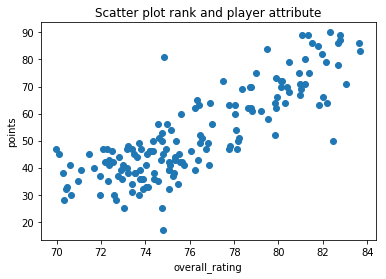

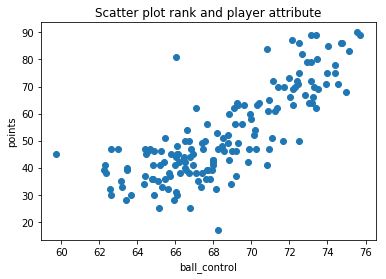

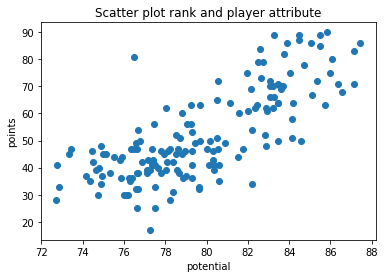

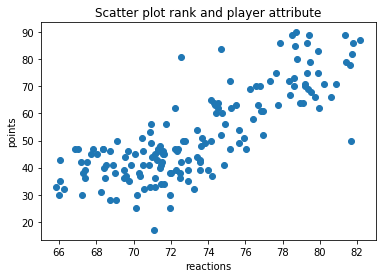

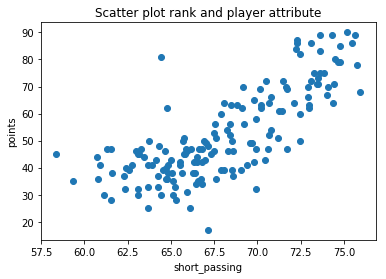

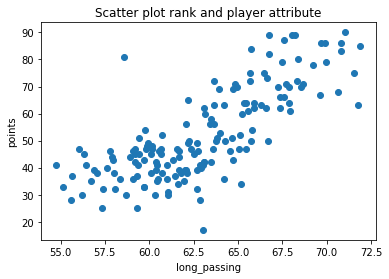

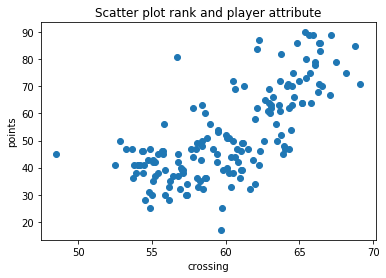

In [43]:
label = 'points'
y = df_all_mean[label]
for col in top_corr_cols:
    x = df_all_mean[col]
    plt.scatter(x,y)
    plt.title('Scatter plot rank and player attribute')
    plt.xlabel(col)
    plt.ylabel(label)
    plt.show()



### Question 2: when is the best/peak age for a soccer player


In [44]:
# get player birthday, overall rating, and rated date
df_age = pd.read_sql('SELECT P.player_api_id, P.player_name, p.birthday, PA.date, PA.overall_rating FROM Player P JOIN Player_Attributes PA on P.player_api_id = PA.player_api_id', conn)
df_age.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 5 columns):
player_api_id     183978 non-null int64
player_name       183978 non-null object
birthday          183978 non-null object
date              183978 non-null object
overall_rating    183142 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 7.0+ MB


In [45]:
# drop missing overall rating
df_age.dropna(inplace=True)
df_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183142 entries, 0 to 183977
Data columns (total 5 columns):
player_api_id     183142 non-null int64
player_name       183142 non-null object
birthday          183142 non-null object
date              183142 non-null object
overall_rating    183142 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 8.4+ MB


In [46]:
# convert object to date
df_age.birthday = pd.to_datetime(df_age.birthday)
df_age.date = pd.to_datetime(df_age.date)
df_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183142 entries, 0 to 183977
Data columns (total 5 columns):
player_api_id     183142 non-null int64
player_name       183142 non-null object
birthday          183142 non-null datetime64[ns]
date              183142 non-null datetime64[ns]
overall_rating    183142 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 8.4+ MB


In [47]:
# calculate age for player at the time rated
df_age['age'] = (df_age.date - df_age.birthday).astype('timedelta64[Y]').astype(int)
df_age[['player_name','birthday','date','age','overall_rating']].head(20)

,player_name,birthday,date,age,overall_rating
0,Aaron Appindangoye,1992-02-29,2016-02-18,23,67.0
1,Aaron Appindangoye,1992-02-29,2015-11-19,23,67.0
2,Aaron Appindangoye,1992-02-29,2015-09-21,23,62.0
3,Aaron Appindangoye,1992-02-29,2015-03-20,23,61.0
4,Aaron Appindangoye,1992-02-29,2007-02-22,14,61.0
5,Aaron Cresswell,1989-12-15,2016-04-21,26,74.0
6,Aaron Cresswell,1989-12-15,2016-04-07,26,74.0
7,Aaron Cresswell,1989-12-15,2016-01-07,26,73.0
8,Aaron Cresswell,1989-12-15,2015-12-24,26,73.0
9,Aaron Cresswell,1989-12-15,2015-12-17,26,73.0


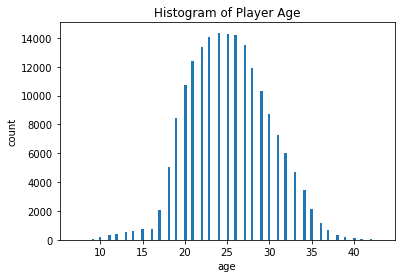

In [48]:
# see age distributed data
label = 'age'
plt.hist(df_age[label],128)
plt.xlabel(label)
plt.ylabel('count')
plt.title('Histogram of Player Age')
plt.show()

> most data from around 20 ~ 30 . so analys this range of age may get the most accuracy

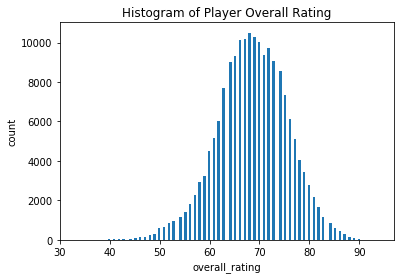

In [49]:
# see overall rating distributed
label = 'overall_rating'
plt.hist(df_age[label],128)
plt.xlabel(label)
plt.ylabel('count')
plt.title('Histogram of Player Overall Rating')
plt.show()

In [50]:
# remove outlier of age
df_age = remove_outlier(df_age,'age')

In [51]:
# which age is the highest overall rating of one player. rank them.
df_age['rank'] = df_age.groupby('player_api_id')['overall_rating'].rank('dense', ascending=False).astype(int)
df_age.head(20)

,player_api_id,player_name,birthday,date,overall_rating,age,rank
0,505942,Aaron Appindangoye,1992-02-29,2016-02-18,67.0,23,1
1,505942,Aaron Appindangoye,1992-02-29,2015-11-19,67.0,23,1
2,505942,Aaron Appindangoye,1992-02-29,2015-09-21,62.0,23,2
3,505942,Aaron Appindangoye,1992-02-29,2015-03-20,61.0,23,3
4,505942,Aaron Appindangoye,1992-02-29,2007-02-22,61.0,14,3
5,155782,Aaron Cresswell,1989-12-15,2016-04-21,74.0,26,1
6,155782,Aaron Cresswell,1989-12-15,2016-04-07,74.0,26,1
7,155782,Aaron Cresswell,1989-12-15,2016-01-07,73.0,26,2
8,155782,Aaron Cresswell,1989-12-15,2015-12-24,73.0,26,2
9,155782,Aaron Cresswell,1989-12-15,2015-12-17,73.0,26,2


In [52]:
# get count group by age
count_by_age = df_age.groupby('age').size()
count_by_age

age
14      600
15      722
16      738
17     2095
18     5055
19     8446
20    10732
21    12380
22    13354
23    14084
24    14356
25    14300
26    14191
27    13472
28    11900
29    10286
30     8733
31     7258
32     6018
33     4708
34     3439
35     2131
36     1137
dtype: int64

In [53]:
# filter rank number 1. because we want to know which age is the best.
df_top_rank = df_age[df_age['rank'] == 1]
df_top_rank.head()

,player_api_id,player_name,birthday,date,overall_rating,age,rank
0,505942,Aaron Appindangoye,1992-02-29,2016-02-18,67.0,23,1
1,505942,Aaron Appindangoye,1992-02-29,2015-11-19,67.0,23,1
5,155782,Aaron Cresswell,1989-12-15,2016-04-21,74.0,26,1
6,155782,Aaron Cresswell,1989-12-15,2016-04-07,74.0,26,1
11,155782,Aaron Cresswell,1989-12-15,2015-09-25,74.0,25,1


In [54]:
# count rank 1 per age
top_rank_by_age = df_top_rank.groupby('age').size()
top_rank_by_age

age
14      83
15      78
16      69
17     180
18     567
19    1286
20    1771
21    2265
22    2565
23    2833
24    2991
25    3002
26    3087
27    2791
28    2311
29    1820
30    1437
31    1009
32     671
33     486
34     265
35     160
36      77
dtype: int64

In [55]:
# we want to know percent of rank 1 on total number of data in the same age.
ratio_age_rank = top_rank_by_age / count_by_age  * 100
ratio_age_rank.dropna(inplace=True)
ratio_age_rank

age
14    13.833333
15    10.803324
16     9.349593
17     8.591885
18    11.216617
19    15.226143
20    16.502050
21    18.295638
22    19.207728
23    20.115024
24    20.834494
25    20.993007
26    21.753224
27    20.717043
28    19.420168
29    17.693953
30    16.454827
31    13.901901
32    11.149884
33    10.322855
34     7.705728
35     7.508212
36     6.772208
dtype: float64

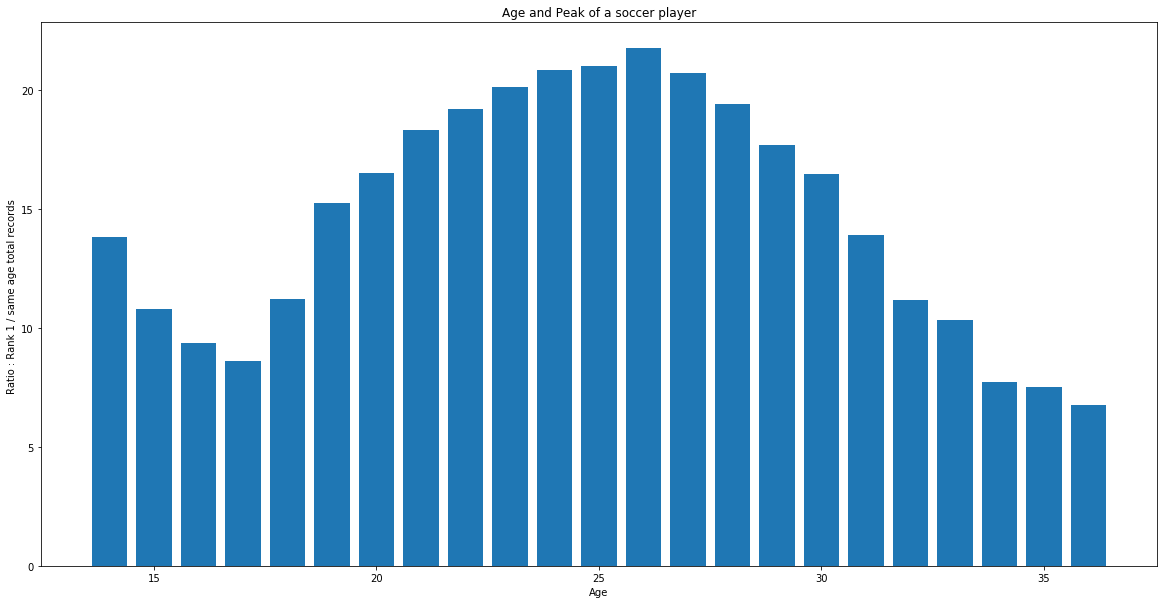

In [56]:
# bar chart
x = ratio_age_rank.index
y = ratio_age_rank.values
fig = plt.figure(figsize = (20, 10))
plt.bar(x,y)
plt.xlabel('Age')
plt.ylabel('Ratio : Rank 1 / same age total records ')
plt.title('Age and Peak of a soccer player')
plt.show()


> 26 years old is the peak of professional soccer player.

### Question 3:  In English Premier League, which team have strongest attack(scores) ?

In [57]:
index_cols = ['team_api_id','season_start_year']
df_final = pd.merge(df_all_mean.set_index(index_cols), df_goal.set_index(index_cols),left_index=True, right_index=True)
df_final = df_final.reset_index()
df_final.head()

,team_api_id,season_start_year,rank,points,team_long_name,team_short_name,preferred_foot,attacking_work_rate,defensive_work_rate,overall_rating,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,goal
0,8191,2009,17,30,Burnley,BUR,2.0,1.966427,1.961631,72.603118,...,63.679856,49.681055,51.394484,46.434053,15.398082,26.796163,61.485612,26.568345,26.568345,42
1,8191,2014,17,33,Burnley,BUR,2.0,2.436059,2.464332,70.479319,...,50.530801,53.545691,54.454216,53.292758,15.806220,15.272727,15.009569,16.222488,15.660287,28
2,8197,2014,13,41,Leicester City,LEI,2.0,2.308612,2.234450,70.607456,...,51.958931,51.675837,55.710327,53.337919,16.383971,15.222488,15.616029,15.068182,15.624402,46
3,8197,2015,1,81,Leicester City,LEI,2.0,2.322967,2.316388,74.861269,...,54.683573,51.740334,58.068077,53.998638,18.693894,16.260538,16.850080,16.718843,16.322397,68
4,8344,2013,19,30,Cardiff City,CAR,2.0,2.297648,2.209800,71.952761,...,54.355466,55.049837,59.204905,56.014887,17.229164,14.716691,14.677564,14.916108,16.830761,32


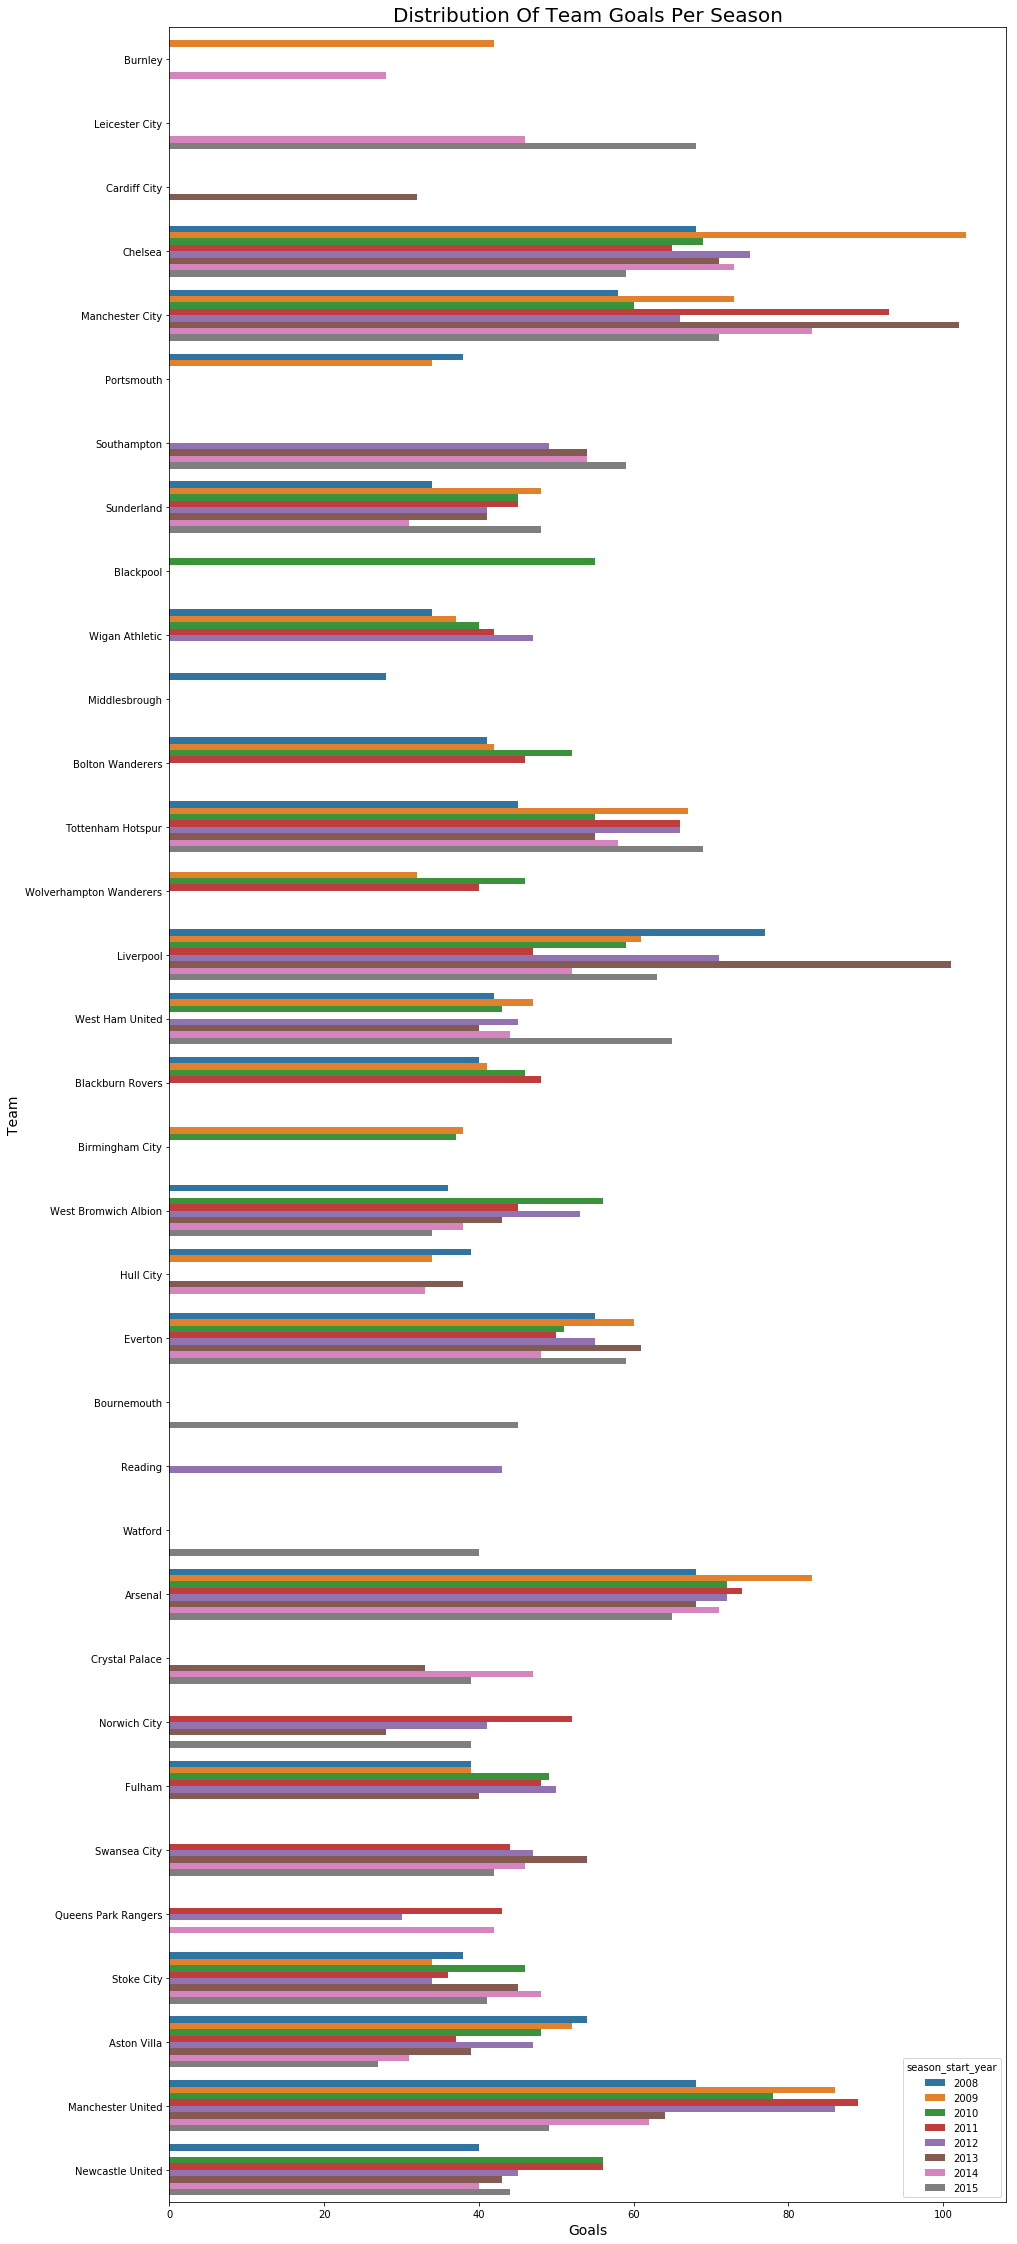

In [58]:
ax = sb.barplot(data=df_final,x='goal', y='team_long_name', hue='season_start_year')
ax.figure.set_size_inches(15, 40);
plt.xlabel('Goals', fontsize=14)
plt.ylabel('Team', fontsize=14)
plt.title("Distribution Of Team Goals Per Season", fontsize=20);

> Goals of teams per year.

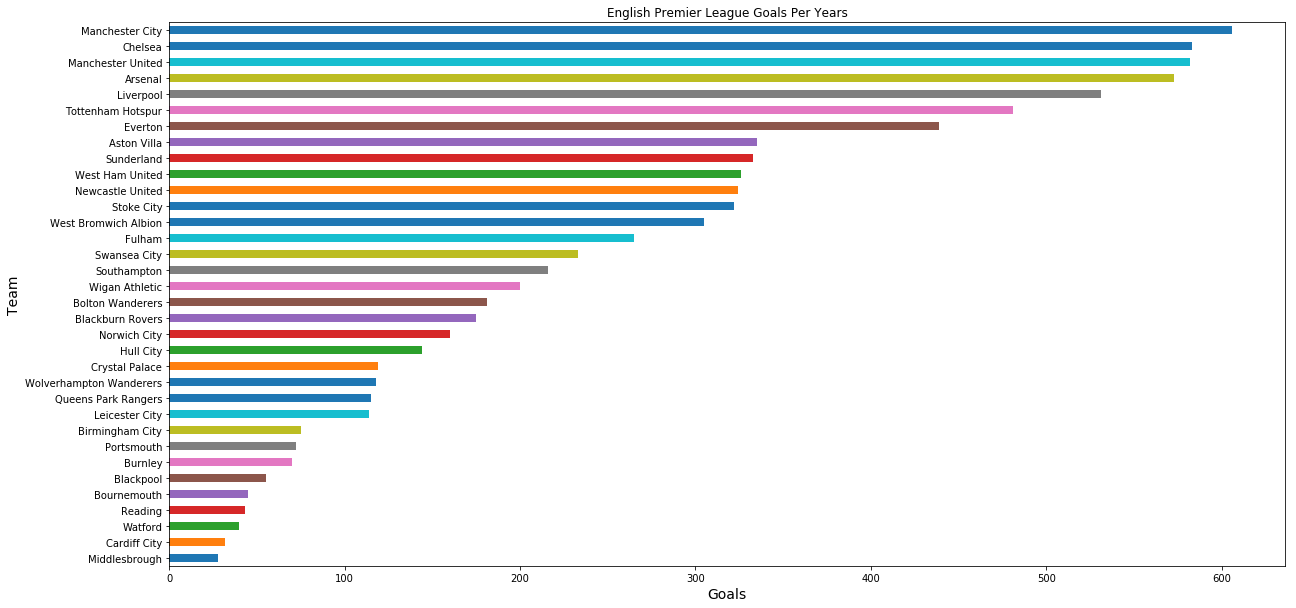

In [59]:
plt.figure(figsize = (20, 10))
df_final.groupby('team_long_name').goal.sum().sort_values().plot.barh()
plt.title('English Premier League Goals Per Years')
plt.xlabel('Goals', fontsize=14)
plt.ylabel('Team', fontsize=14)

plt.show()

> Manchester City is the strongest team in attacking. They scored the best.

### Question 4: In English Premier League, which team got most points ?

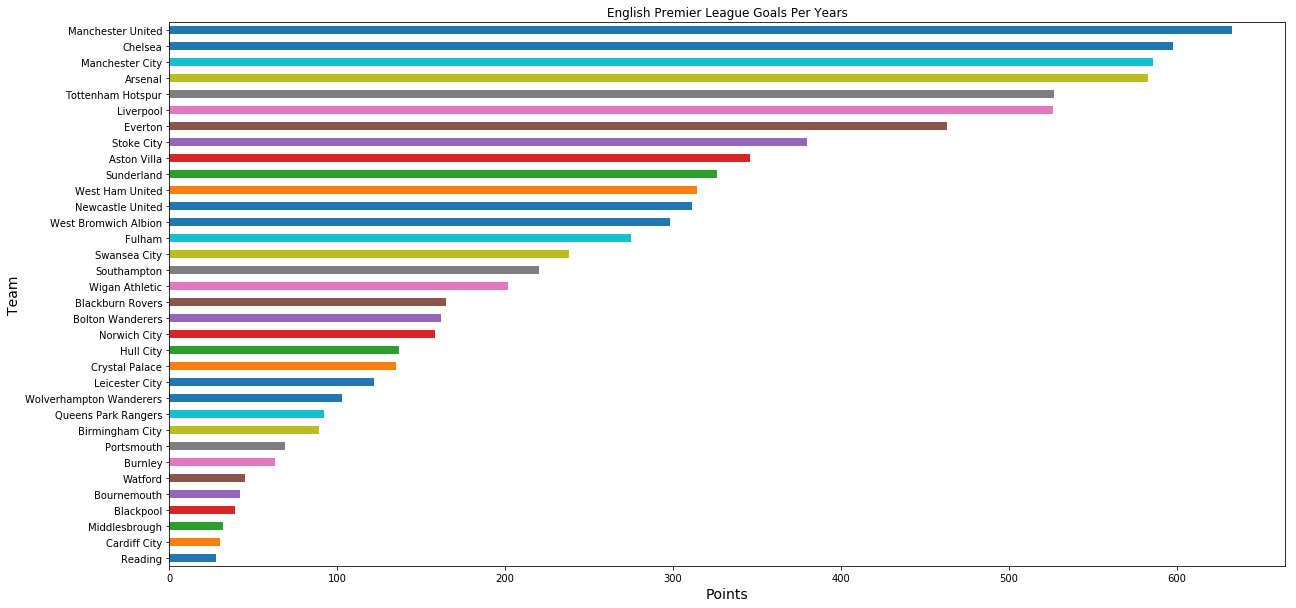

In [60]:
plt.figure(figsize = (20, 10))
df_final.groupby('team_long_name').points.sum().sort_values().plot.barh()
plt.title('English Premier League Goals Per Years')
plt.xlabel('Points', fontsize=14)
plt.ylabel('Team', fontsize=14)

plt.show()

> Manchester United is the team that got the most points.

### Question 5: Which season in English Premier League has the most goals ?

Text(0.5,1,'English Premier League Goals Per Years')

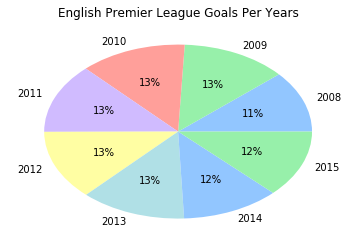

In [61]:
colors = sb.color_palette('pastel')[0:30]
series = df_final.groupby('season_start_year').goal.sum().sort_index()
plt.pie(series,labels=series.index, colors = colors ,autopct='%.0f%%')
plt.title('English Premier League Goals Per Years')

> The goals per year not changed much.

Text(0,0.5,'Goals')

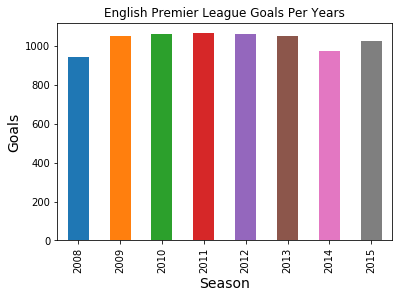

In [62]:
df_final.groupby('season_start_year').goal.sum().sort_index().plot.bar()
plt.title('English Premier League Goals Per Years')
plt.xlabel('Season', fontsize=14)
plt.ylabel('Goals', fontsize=14)

In [63]:
df_final.groupby('season_start_year').goal.sum().sort_values()

season_start_year
2008     942
2014     975
2015    1026
2013    1052
2009    1053
2010    1063
2012    1063
2011    1066
Name: goal, dtype: int64

> 2011 is the season with highest goals scored.

<a id='conclusions'></a>
## Conclusion
* below attributes are the most important to success of a team. Because correlation of these attributes with rank of season is very strong.
> ball_control,
> potential,
> reactions,
> short_passing,
> long_passing,
> crossing

* all attributes above are belongs to midfield player, so maybe midfield is the most important ( ofcourse balance of the team is important too )
* 26 is the peak of a player. Afer this age almost players overall will be decrease.
* Manchester City is the team scored more goals than all other teams in English Premier League.
* Manchester United is the team got more points than all other teams in English Premier League.
* 2011 is the season with highest goals scored

## Limitation:
There are some limitations listed below that impace the result and performance of the analysis tasks:
* Some teams only played in English Premier League one or two seasons, so the goals/points summary for this teams are not accuracy.
* Some player attributes missing.
* some columns about event of match have html tag
* with little documentation about the dataset , it is hard to choose column to analyis.